In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from tensorflow.keras import layers

import os
import shutil

In [2]:
DATASET_PATH = 'Automating_Port_Operations_dataset'

# Courtesy of SimpliLearn for providing os commands regarding train_test_split on directories, which I've never learned
def copy_files(img_paths, img_classes, target):
    for img_path, img_class  in zip(img_paths, img_classes):
        dest_dir = os.path.join(target, img_class)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, dest_dir)

def train_test_dir(test_size, rand, data_dir=DATASET_PATH, train_dir=DATASET_PATH+"/train", test_dir=DATASET_PATH+'/test') :
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    path_list = []
    classes = []

    for folder in os.listdir(data_dir) :
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path) :
            for file in os.listdir(folder_path) :
                if file.endswith('.jpg') :
                    path_list.append(os.path.join(folder_path, file))
                    classes.append(folder)

    train_paths, test_paths, train_classes, test_classes = train_test_split(path_list, classes, test_size=test_size, random_state=rand, shuffle=True)

    copy_files(train_paths, train_classes, train_dir)
    copy_files(test_paths, test_classes, test_dir)


# CNN

In [3]:
# Batch size, image size
BAT_SIZE, IMG_SIZE = 32, 180

train_test_dir(0.2, 43)

train = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/train",
                                                            label_mode = 'categorical',
                                                            validation_split = 0.2,
                                                            shuffle = True,
                                                            seed = 43,
                                                            subset = 'training',
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)
val = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/train",
                                                            label_mode = 'categorical',
                                                            validation_split = 0.2,
                                                            shuffle = True,
                                                            seed = 43,
                                                            subset = 'validation',
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)
test = train = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/test",
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 43,
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)

class_names = train.class_names

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 1083 files belonging to 9 classes.
Using 867 files for training.
Found 1083 files belonging to 9 classes.
Using 216 files for validation.
Found 503 files belonging to 9 classes.


In [4]:
model = tf.keras.models.Sequential([
                                    layers.Rescaling(1./255, input_shape = (IMG_SIZE, IMG_SIZE, 3)),
                                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                                    layers.MaxPooling2D(),
                                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                                    layers.MaxPooling2D(),
                                    layers.GlobalAveragePooling2D(),
                                    layers.Flatten(),
                                    layers.Dense(128, activation='relu'),
                                    layers.Dense(128, activation='relu'),
                                    layers.Dense(9, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Uncomment for model layout
# print(model.summary())

hist = model.fit(train,
                 validation_data=val,
                 epochs = 20)

acc = hist.history['accuracy']
v_acc = hist.history['val_accuracy']
loss = hist.history['loss']
v_loss = hist.history['val_loss']


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.2523 - loss: 2.1046 - precision: 0.1765 - recall: 0.0018 - val_accuracy: 0.3380 - val_loss: 1.9057 - val_precision: 0.4478 - val_recall: 0.1389
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.3425 - loss: 1.8286 - precision: 0.4745 - recall: 0.0947 - val_accuracy: 0.3380 - val_loss: 1.8466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3589 - loss: 1.7776 - precision: 0.4941 - recall: 0.0078 - val_accuracy: 0.3380 - val_loss: 1.8323 - val_precision: 0.4000 - val_recall: 0.0093
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.3101 - loss: 1.8079 - precision: 0.0882 - recall: 7.0167e-04 - val_accuracy: 0.3426 - val_loss: 1.8138 - val_precision: 0.6000 - val_recall: 0.0417
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3774 - loss: 1.7365 - precision: 0.7921 - recall: 0.0597 - val_accuracy: 0.3472 - 

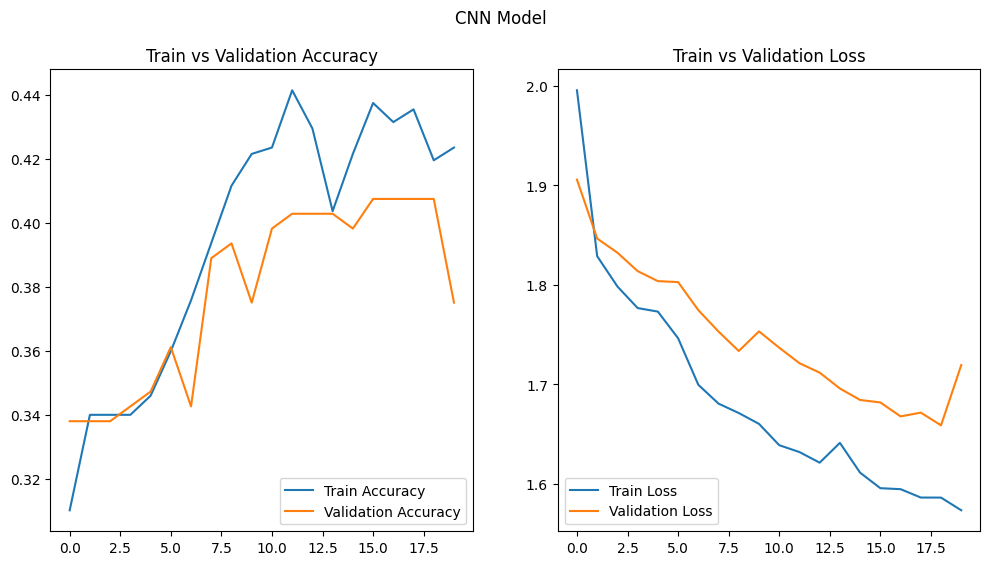

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Train Accuracy')
plt.plot(range(20), v_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Train Loss')
plt.plot(range(20), v_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Train vs Validation Loss')

plt.suptitle('CNN Model')
plt.show()

In [6]:
predicts = model.predict(test)
predict = np.argmax(predicts, axis=1)
true = np.argmax(tf.concat([y for x, y in test], axis=0), axis=1)

# print(f"\nAccuracy score: {accuracy_score(true, predict)}")
# print(f"Mean Squared Error: {mean_squared_error(true, predict)}\n")

model.evaluate(test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4173 - loss: 1.5982 - precision: 0.5923 - recall: 0.1523


[1.6276891231536865,
 0.3956262469291687,
 0.5813953280448914,
 0.14910537004470825]

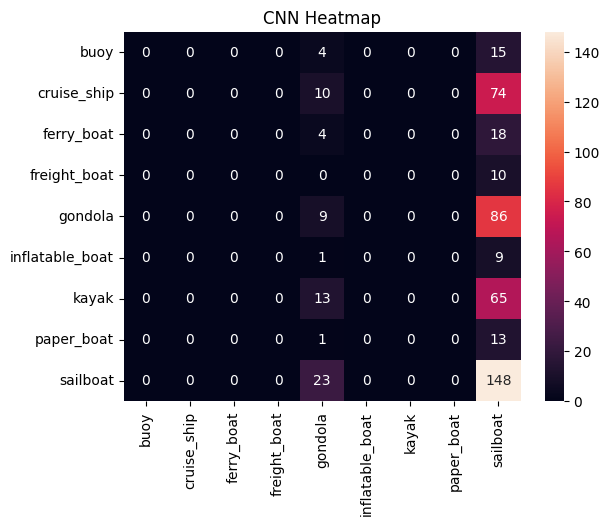

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        10
           4       0.14      0.09      0.11        95
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        14
           8       0.34      0.87      0.49       171

    accuracy                           0.31       503
   macro avg       0.05      0.11      0.07       503
weighted avg       0.14      0.31      0.19       503



In [7]:
import seaborn as sns

sns.heatmap(confusion_matrix(true, predict), annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Heatmap')
plt.show()

print(classification_report(true, predict))

# MobileNet

In [8]:
train_test_dir(0.3, 1)
train = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/train",
                                                            label_mode = 'categorical',
                                                            validation_split = 0.3,
                                                            shuffle = True,
                                                            seed = 1,
                                                            subset = 'training',
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)
val = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/train",
                                                            label_mode = 'categorical',
                                                            validation_split = 0.3,
                                                            shuffle = True,
                                                            seed = 1,
                                                            subset = 'validation',
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)
test = train = tf.keras.preprocessing.image_dataset_from_directory(DATASET_PATH + "/test",
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 1,
                                                            image_size = (IMG_SIZE, IMG_SIZE),
                                                            batch_size = BAT_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 1083 files belonging to 9 classes.
Using 759 files for training.
Found 1083 files belonging to 9 classes.
Using 324 files for validation.
Found 503 files belonging to 9 classes.


In [9]:
mn_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_SIZE, IMG_SIZE, 3),
                                             include_top=False)
mn_model.trainable = False

# Uncomment for MobileNet model summary
# print(mn_model.summary())

# inputs
i = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# hidden
x = layers.Rescaling(1./255)(i)
x = mn_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

#outputs
o = layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(i, o)

# Uncomment for final model summary
# print(model.summary())

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(train,
                 validation_data = val,
                 epochs = 50,
                 callbacks=[callback])

acc = hist.history['accuracy']
v_acc = hist.history['val_accuracy']
loss = hist.history['loss']
v_loss = hist.history['val_loss']


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.4118 - loss: 1.7864 - precision: 0.5920 - recall: 0.2750 - val_accuracy: 0.6358 - val_loss: 1.1212 - val_precision: 0.8962 - val_recall: 0.5062
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.8185 - loss: 0.6302 - precision: 0.9207 - recall: 0.7229 - val_accuracy: 0.7284 - val_loss: 0.8148 - val_precision: 0.8734 - val_recall: 0.6389
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9018 - loss: 0.3420 - precision: 0.9547 - recall: 0.8400 - val_accuracy: 0.8025 - val_loss: 0.6178 - val_precision: 0.8931 - val_recall: 0.7222
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9527 - loss: 0.1844 - precision: 0.9732 - recall: 0.9256 - val_accuracy: 0.8580 - val_loss: 0.5140 - val_precision: 0.9184 - val_recall: 0.7994
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.9781 - loss: 0.1265 - precision: 0.9836 - recall: 0.9462 - val_accuracy: 0.8735 - val_loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9989 - loss: 0.0238 - precision: 0.9989 - recall: 0.9964


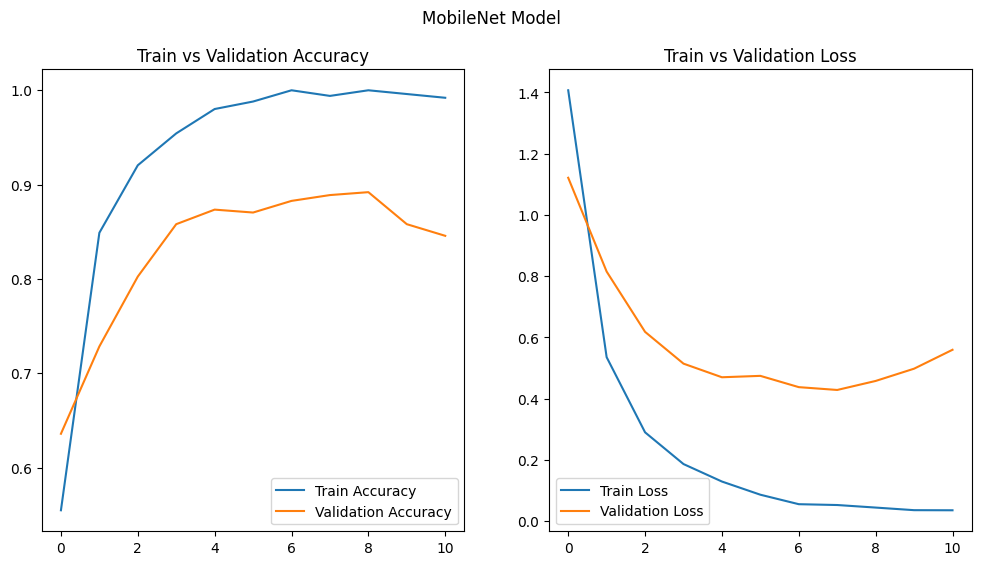

In [10]:
model.evaluate(test)

num_iters = len(hist.history['loss'])

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(range(num_iters), acc, label='Train Accuracy')
plt.plot(range(num_iters), v_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(num_iters), loss, label='Train Loss')
plt.plot(range(num_iters), v_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Train vs Validation Loss')

plt.suptitle('MobileNet Model')
plt.show()

# Closing Statement

MobileNet's model can achieve more than twice the accuracy & a much less loss score than base CNN's model in less epochs. This is due to:

1. MobileNet having a more elaborate model - not only in having extra layers for dropout, but in the transfer model itself.

2. MobileNet is already a prefixed model that has been transferred over, meaning it is capable of being more accurate and precise than the crudely assembled CNN model.

However, base CNN's model has less of a divergence in the train-validation loss score compared to MobileNet. For example, there is a 0.1 difference in loss in the base CNN, compared to MobileNet's 0.6 difference. This is perhaps a drawback to MobileNet's more scrutinized model, with the extra layers causing a higher variation in score.